In [510]:
from pathlib import Path
from timesformer.models.vit import *
from timesformer.datasets import utils as utils
from timesformer.datasets import loader
from timesformer.datasets import video_container as container
from timesformer.datasets import decoder as decoder
from timesformer.config.defaults import get_cfg
from einops import rearrange, repeat, reduce
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [511]:
import numpy as np

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [512]:
#helpers for visualizing attention masks
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / (255*3.5)
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def create_masks(masks_in, np_imgs):
  masks = []
  for mask, img in zip(masks_in, np_imgs):
    mask= cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask = show_mask_on_image(img, mask)
    masks.append(mask)
  return(masks)

In [513]:
#attention rollout class
def combine_divided_attention(attn_t, attn_s):
  ## time attention
    # average time attention weights across heads
  attn_t = attn_t.mean(dim = 1)
    # add cls_token to attn_t as an identity matrix since it only attends to itself 
  I = torch.eye(attn_t.size(-1)).unsqueeze(0)
  attn_t = torch.cat([I,attn_t], 0)
    # adding identity matrix to account for skipped connection 
  attn_t = attn_t +  torch.eye(attn_t.size(-1))[None,...]
    # renormalize
  attn_t = attn_t / attn_t.sum(-1)[...,None]

  ## space attention
   # average across heads
  attn_s = attn_s.mean(dim = 1)
   # adding residual and renormalize 
  attn_s = attn_s +  torch.eye(attn_s.size(-1))[None,...]
  attn_s = attn_s / attn_s.sum(-1)[...,None]
  
  ## combine the space and time attention
  attn_ts = einsum('tpk, ktq -> ptkq', attn_s, attn_t)
  
  ## average the cls_token attention across the frames
   # splice out the attention for cls_token
  attn_cls = attn_ts[0,:,:,:]
   # average the cls_token attention and repeat across the frames
  attn_cls_a = attn_cls.mean(dim=0)
  attn_cls_a = repeat(attn_cls_a, 'p t -> j p t', j = 8)
   # add it back
  attn_ts = torch.cat([attn_cls_a.unsqueeze(0),attn_ts[1:,:,:,:]],0)
  return(attn_ts)

class DividedAttentionRollout():
  def __init__(self, model, **kwargs):
    self.model = model
    self.hooks = []

  def get_attn_t(self, module, input, output):
    self.time_attentions.append(output.detach().cpu())
  def get_attn_s(self, module, input, output):
    self.space_attentions.append(output.detach().cpu())

  def remove_hooks(self): 
    for h in self.hooks: h.remove()
    
  def __call__(self, video):
    input_tensor = video
    self.model.zero_grad()
    self.time_attentions = []
    self.space_attentions = []
    self.attentions = []
    for name, m in self.model.named_modules():
      if 'temporal_attn.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_t))
      elif 'attn.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_s))
    preds = self.model(input_tensor)
    for h in self.hooks: h.remove()
    for attn_t,attn_s in zip(self.time_attentions, self.space_attentions):
      self.attentions.append(combine_divided_attention(attn_t,attn_s))
    p,t = self.attentions[0].shape[0], self.attentions[0].shape[1]
    result = torch.eye(p*t)
    for attention in self.attentions:
      attention = rearrange(attention, 'p1 t1 p2 t2 -> (p1 t1) (p2 t2)')
      result = torch.matmul(attention, result)
    mask = rearrange(result, '(p1 t1) (p2 t2) -> p1 t1 p2 t2', p1 = p, p2=p)
    mask = mask.mean(dim=1)
    mask = mask[0,1:,:]
    width = int(mask.size(0)**0.5)
    mask = rearrange(mask, '(h w) t -> h w t', w = width).numpy()
    mask = mask / np.max(mask)
    return(mask), preds

In [514]:
camera_view = "ego_vlp_pretrain"
model_file = "/vision/asomaya1/ego_exo/ProficiencyEstimation/TimeSformer/outputs/448p/" + camera_view
model_file = model_file + "/checkpoints/checkpoint_epoch_00050.pyth"

In [515]:
cfg = get_cfg()
cfg.merge_from_file('/vision/asomaya1/ego_exo/ProficiencyEstimation/TimeSformer/configs/EgoExo/TimeSformer_divST_16x16_448.yaml')
cfg.TRAIN.ENABLE = False
cfg.TIMESFORMER.PRETRAINED_MODEL = model_file
cfg.DATA.CAMERA_VIEW = camera_view
cfg.OUTPUT_DIR = "./outputs/448p/" + camera_view
cfg.TEST.CHECKPOINT_FILE_PATH = model_file
model = MODEL_REGISTRY.get('vit_base_patch16_224')(cfg)

In [516]:
#prefix = '/vision/vision_data/Exo2Ego/original_dataset/proficiency_estimation/takes_448p/'
#path_to_video = prefix + 
path_to_video = "/vision/vision_data/Exo2Ego/original_dataset/proficiency_estimation/takes_448p/iiith_cooking_75_2/frame_aligned_videos/cam01.mp4"
label = 3
#/vision/vision_data/Exo2Ego/original_dataset/proficiency_estimation/takes_448p/unc_basketball_03-30-23_02_8/frame_aligned_videos/aria02_214-1.mp4
#/vision/vision_data/Exo2Ego/original_dataset/proficiency_estimation/takes_448p/unc_basketball_02-24-23_02_12/frame_aligned_videos/cam01.mp4
#upenn_0701_Piano_1_3/frame_aligned_videos/gp02.mp4
#"/vision/vision_data/Exo2Ego/original_dataset/proficiency_estimation/takes_448p/unc_basketball_03-17-23_01_24/frame_aligned_videos/aria01_214-1.mp4"


In [517]:
video_container = None
video_container = container.get_video_container(
    path_to_video,
    cfg.DATA_LOADER.ENABLE_MULTI_THREAD_DECODE,
    cfg.DATA.DECODING_BACKEND,
)

In [518]:
# Decode video. Meta info is used to perform selective decoding.
frames = decoder.decode(
    video_container,
    cfg.DATA.SAMPLING_RATE,
    cfg.DATA.NUM_FRAMES,
    num_clips=cfg.TEST.NUM_ENSEMBLE_VIEWS,
    target_fps=cfg.DATA.TARGET_FPS,
    backend=cfg.DATA.DECODING_BACKEND,
    max_spatial_scale=cfg.DATA.TEST_CROP_SIZE,
)

frames_orig = frames

# Perform color normalization.
frames = utils.tensor_normalize(
    frames, cfg.DATA.MEAN, cfg.DATA.STD
)

spatial_index = 1
# T H W C -> C T H W.
frames = frames.permute(3, 0, 1, 2)
# Perform data augmentation.
frames = utils.spatial_sampling(
    frames,
    spatial_idx=spatial_index,
    min_scale=cfg.DATA.TEST_CROP_SIZE,
    max_scale=cfg.DATA.TEST_CROP_SIZE,
    crop_size=cfg.DATA.TEST_CROP_SIZE,
    random_horizontal_flip=cfg.DATA.RANDOM_FLIP,
    inverse_uniform_sampling=cfg.DATA.INV_UNIFORM_SAMPLE,
)

# T H W C -> C T H W.
frames_orig = frames_orig.permute(3, 0, 1, 2)
# Perform data augmentation.
frames_orig = utils.spatial_sampling(
    frames_orig,
    spatial_idx=spatial_index,
    min_scale=cfg.DATA.TEST_CROP_SIZE,
    max_scale=cfg.DATA.TEST_CROP_SIZE,
    crop_size=cfg.DATA.TEST_CROP_SIZE,
    random_horizontal_flip=cfg.DATA.RANDOM_FLIP,
    inverse_uniform_sampling=cfg.DATA.INV_UNIFORM_SAMPLE,
)

frames = torch.index_select(
        frames,
        1,
        torch.linspace(
            0, frames.shape[1] - 1, cfg.DATA.NUM_FRAMES

        ).long(),
).unsqueeze(0)

frames_orig = torch.index_select(
        frames_orig,
        1,
        torch.linspace(
            0, frames_orig.shape[1] - 1, cfg.DATA.NUM_FRAMES

        ).long(),
).unsqueeze(0)

In [519]:
att_roll = DividedAttentionRollout(model)
masks, preds = att_roll(frames)

In [520]:
softmax_probs = F.softmax(preds, dim=1)

In [521]:
for i, prob in enumerate(softmax_probs[0]):
    print("class", str(i) + ":", prob.item())
print("true class:", label)

class 0: 0.14350679516792297
class 1: 0.027199964970350266
class 2: 0.5390989184379578
class 3: 0.29019424319267273
true class: 3


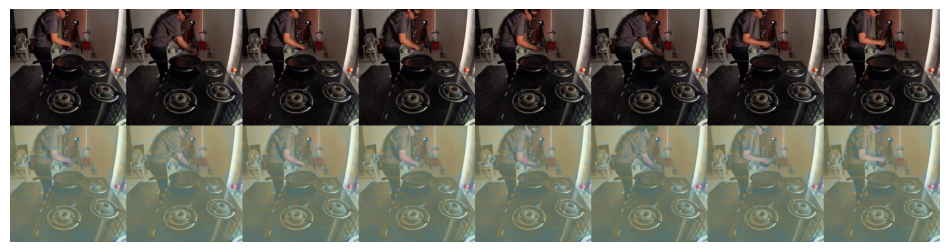

In [522]:
np_imgs = [np.array(p.permute(1,2,0))for p in frames_orig[0].transpose(1,0)]
masks_new = create_masks(list(rearrange(masks, 'h w t -> t h w')),np_imgs)

plt.figure(figsize=(12, 10))
plt.axis('off')
plt.imshow(np.vstack((np.hstack(np_imgs), np.hstack(masks_new))))

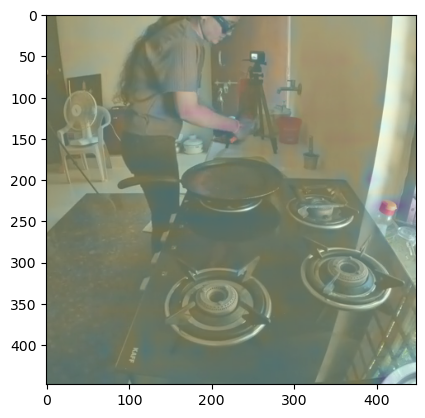

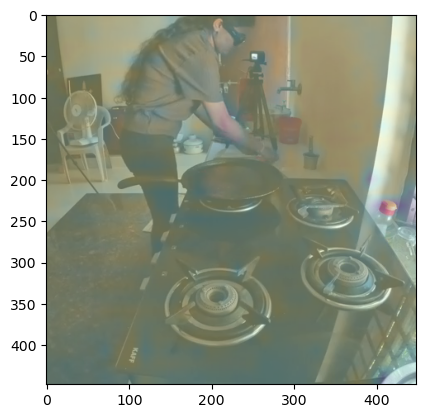

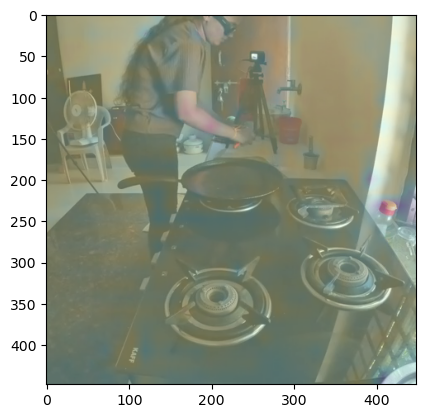

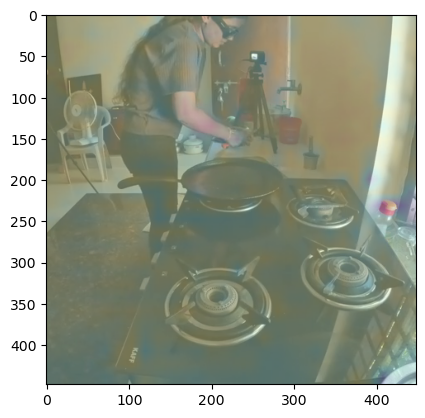

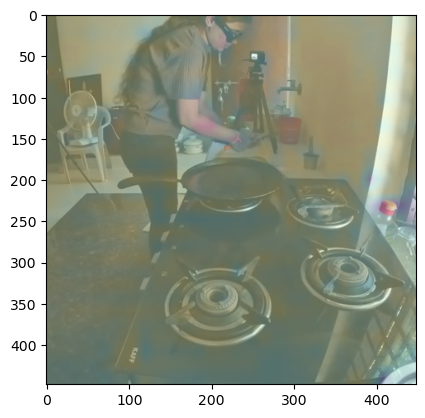

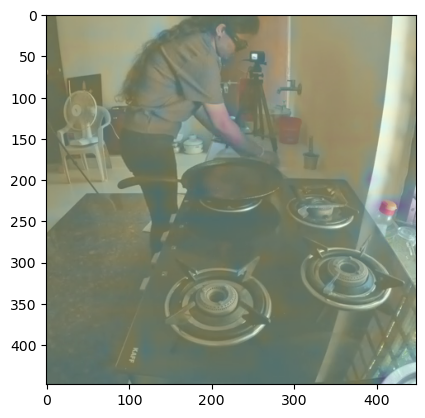

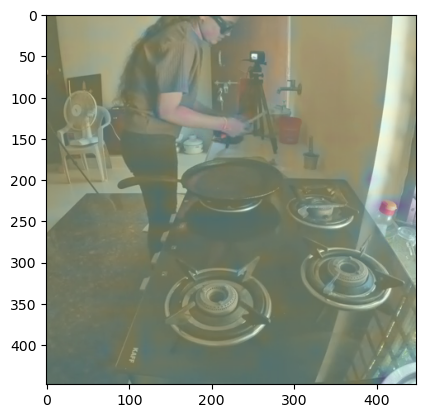

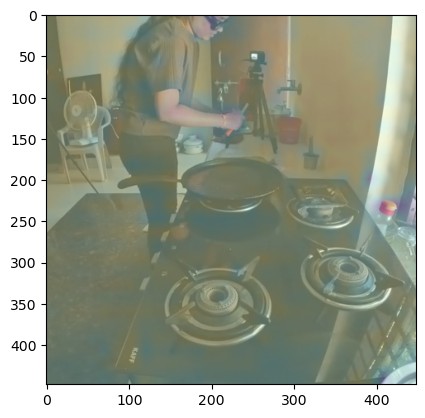

In [523]:
for mask in masks_new:
    plt.imshow(mask)
    plt.show()